I am going to create a linear algebra model for predicting total infections. The equation will take the form of: y = a*x1 + b*x2 + c*x1*x2 + d, where y is infections per capita, x1 is the log10 of transportation usage, x2 is the log10 of population density, all by county. I predict the error of this linear model will be fairly high, and most of the effect will come from the intercept. I predict this because the data vizualization seems very noisy when plotted log log.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import statsmodels.api as sm
import math

data = pd.DataFrame(pd.read_csv(r"C:\Users\mdsnb\OneDrive\Documents\GitHub\ChE_2410_Math\Project 1\county_withpop.csv"))
print(data.head())

logdensity = data['logdensity'].values
infperpop = data['infperpop'].values
logtrans = data['logtrans'].values
interaction = np.multiply(logtrans, logdensity)
intercept = np.ones(len(logdensity))

matrix = np.vstack((intercept, logtrans, logdensity, interaction)).T

tmp = inv(np.matmul(np.transpose(matrix), matrix))

interceptvalue, slopetrans, slopedensity, slopeinteraction = tmp @ np.transpose(matrix) @ infperpop

print('Intercept is:', interceptvalue, "slope trans is:", slopetrans, 'slope density is:', slopedensity, 'slope interaction is:',slopeinteraction)

#verification via OLS below. math checks out.
model = sm.OLS(infperpop, matrix).fit()
print(model.summary())

   Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0          County    State  \
0             0             0           0  Autauga County  Alabama   
1             1             1           1  Baldwin County  Alabama   
2             2             2           2  Barbour County  Alabama   
3             3             3           3     Bibb County  Alabama   
4             4             4           4   Blount County  Alabama   

   Total infections    Density  Public Transportation Usage  logdensity  \
0           2871893  35.853419                     0.000782    1.554531   
1           9751057  50.541504                     0.002143    1.703648   
2            983791  11.247981                     0.003984    1.051075   
3           1144559  13.973114                     0.004710    1.145293   
4           2851498  34.515816                     0.001639    1.538018   

     loginf  logtrans  logd*t interaction  Population  infperpop  loginfperpop  
0  6.458168 -3.106853          -20.064577      

From this data there is reason to believe that we should filter by counties that have public transportation as an option. By removing all data entries with public transportation entries that are exactly 0 we should be able to see infection rates relative to public transportation ~in areas that offer public transportation~.

EDIT 10/14/22: The data has now been filtered. Previously the data was pulled from line 11 which is now commented out

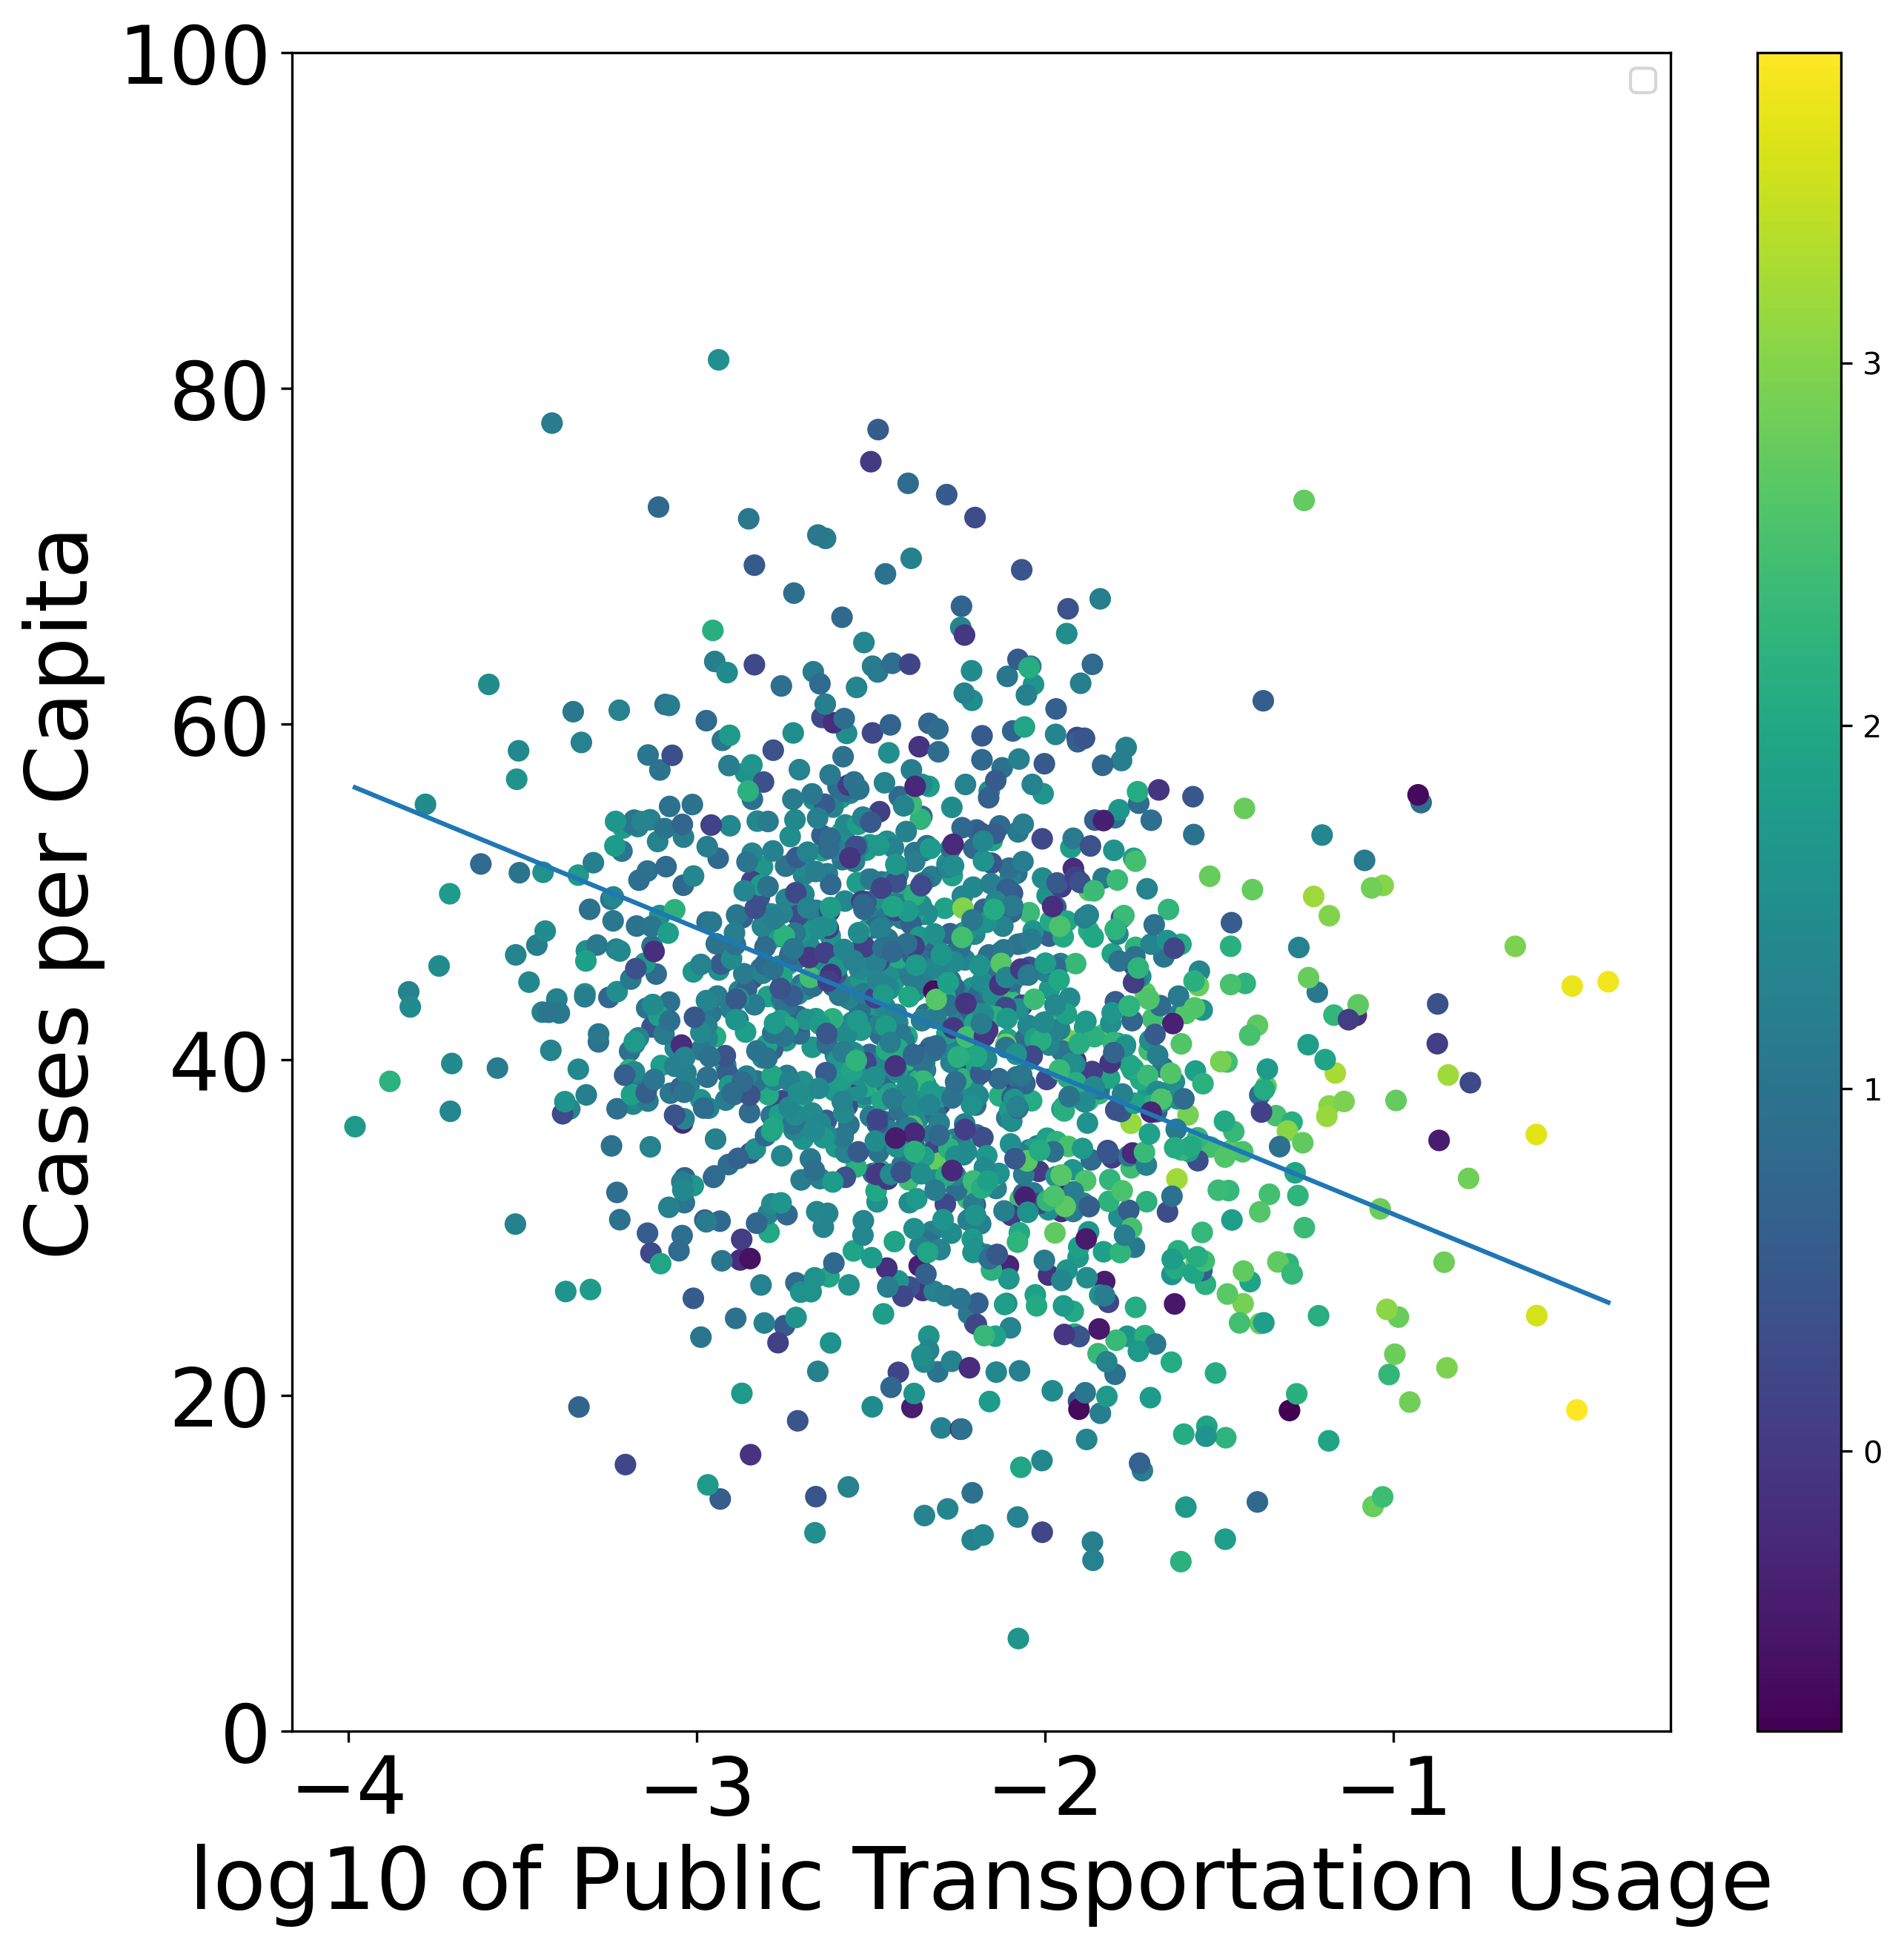

In [3]:
x1i = np.min(logtrans)
x1f = np.max(logtrans)
x2i = np.min(logdensity)
x2f = np.max(logdensity)
x3i = np.min(interaction)
x3f = np.max(interaction)
yi = interceptvalue + slopetrans*x1i+slopedensity*x2i+slopeinteraction*x3i
yf = interceptvalue + slopetrans*x1f+slopedensity*x2f+slopeinteraction*x3f
xarray = ([x1i, x1f])
yarray = ([yi, yf])
fig, ax = plt.subplots(figsize = (10, 10), dpi = 300)
plt.scatter(logtrans, infperpop, c = logdensity)
plt.plot(xarray, yarray)
plt.xlabel('log10 of Public Transportation Usage', fontsize = 28)
plt.ylabel('Cases per Capita', fontsize = 28)
plt.ylim(0, 100)
ax.set(title='')
plt.legend('').set_alpha(0)
plt.colorbar()
plt.tick_params(labelsize=26)

Now I'm going to create a nonlinear model, hopefully to capture the shape of the data drawn above. I don't predict this is very likely; the data seem to have no clear relationship. Even if there is an effect from population density and/or the interactions thereof, it's not likely it's substantial based on linear model slope information: the intercept is substantially larger than any other slope value, meaning it likely simply represents the average total infections.

In [4]:
from scipy.optimize import minimize
import math

errorvals = []
avals = []
bvals = []
cvals = []
bipolarrange = 1000
steps = 10
incrementsize = math.floor((bipolarrange*2)/steps)

if steps >= 20: 
    print('number of combinations is:', steps**3, 'which may take a minute')

def error(params):
        a, b, c = params
        #array of guesses
        y = ((a + logtrans) / logdensity) + b*interaction + c
        #print(err)
        return np.sum((y-infperpop)**2)

for a in range(-bipolarrange, bipolarrange, incrementsize):
    for b in range (-bipolarrange, bipolarrange, incrementsize):
        for c in range (-bipolarrange, bipolarrange, incrementsize):
            ic = [a, b, c]
            sol = minimize(error, ic)
            avals.append(sol.x[0])
            bvals.append(sol.x[1])
            cvals.append(sol.x[2])
            errorvals.append(error(ic))

Plotting a, b, c, and error function values to see what we can learn

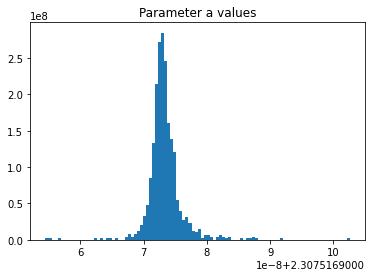

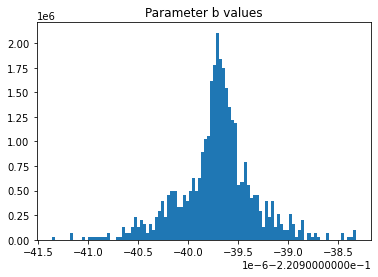

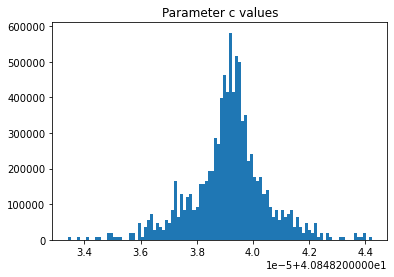

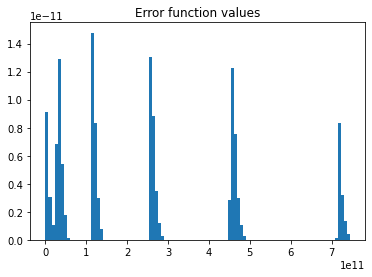

In [5]:
bins = 100

plt.hist(avals, density = True, bins = bins)
plt.title('Parameter a values')
plt.show()
plt.hist(bvals, density = True, bins = bins)
plt.title('Parameter b values')
plt.show()
plt.hist(cvals, density = True, bins = bins)
plt.title('Parameter c values')
plt.show()
plt.hist(errorvals, density = True, bins = bins)
plt.title('Error function values')
plt.show()

Plotting our fits. The nonlinear solution below is commented out to produce the final graphic, but it can be uncommented to see its fit.

[]

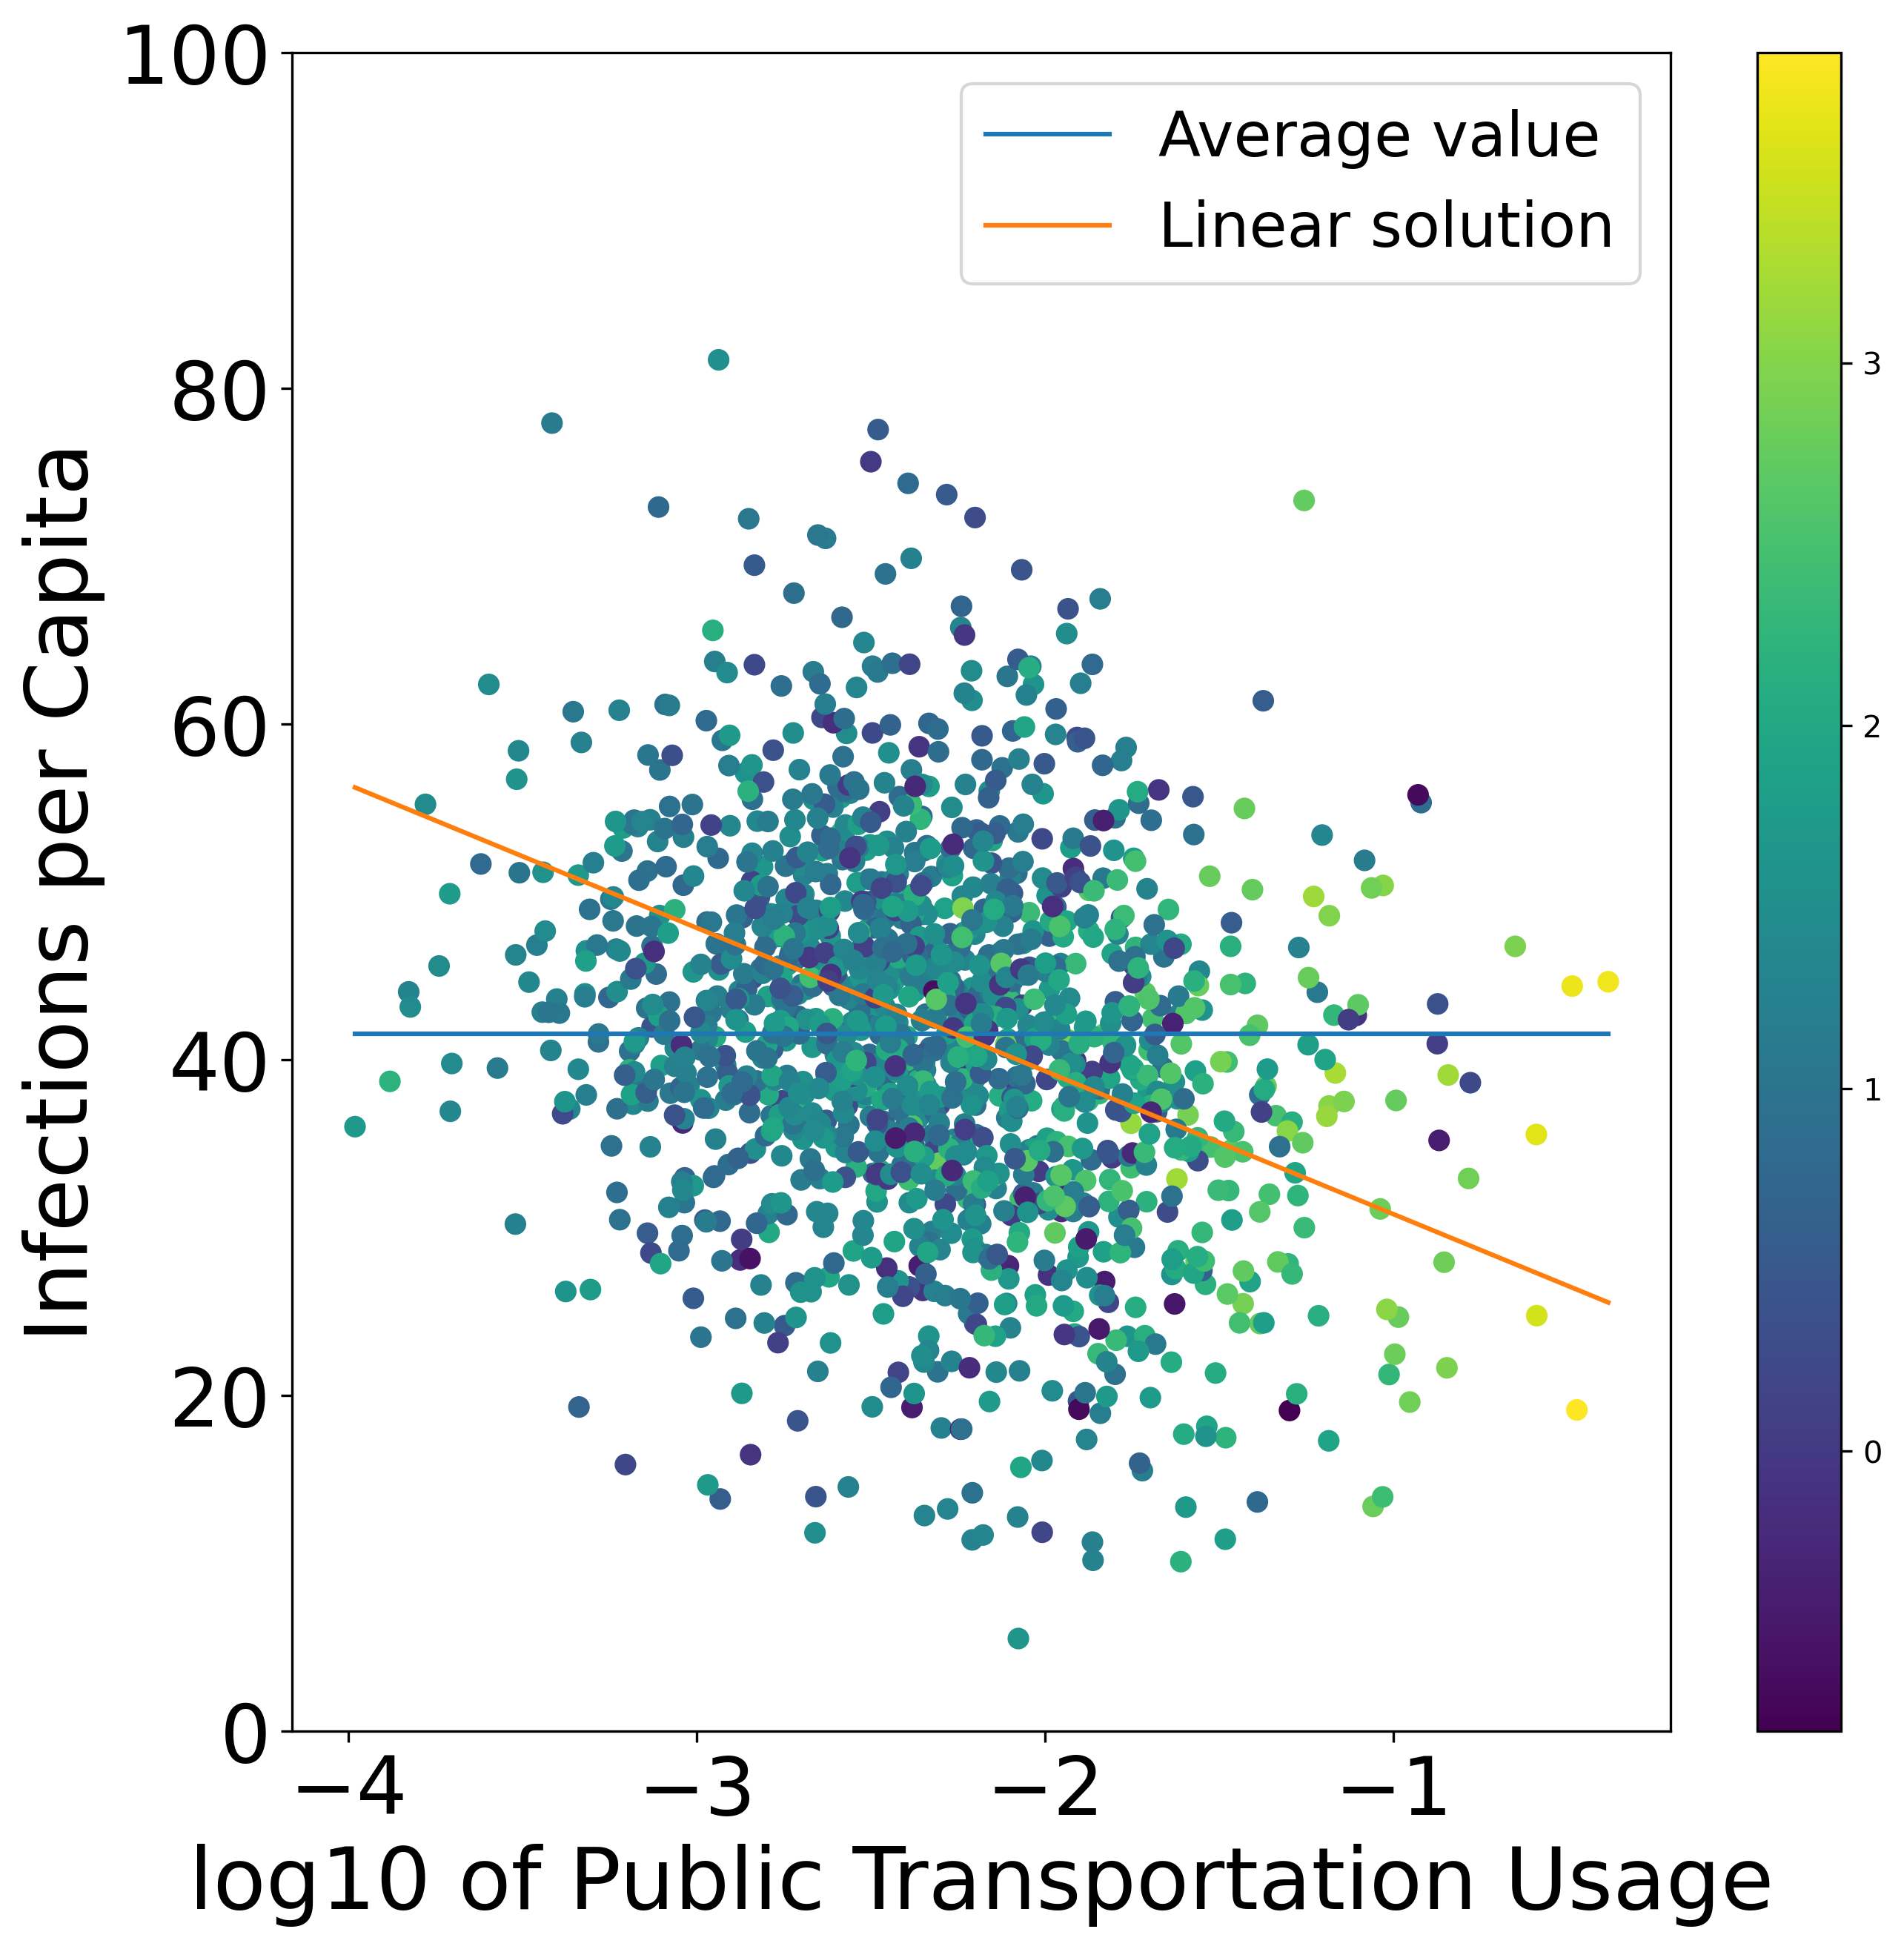

In [6]:
gooderrorvals = []
goodavals = []
goodbvals = []
goodcvals = []

for k in range(len(cvals)):
    
    #choosing the bottom 10% errorvals and their associated parameter values
    if errorvals[k] <= ((np.max(errorvals)-np.min(errorvals)/10)+np.min(errorvals)):
        gooderrorvals.append(errorvals[k])
        goodavals.append(avals[k])
        goodbvals.append(bvals[k])
        goodcvals.append(cvals[k])

#getting final paramter values
gooda = np.average(goodavals)
goodb = np.average(goodbvals)
goodc = np.average(goodcvals)

#making our nonlinear function
def nonlinmodel(params):
    x1, x2, x3 = params
    y = ((gooda + x1) / x2) + goodb*x3 + goodc
    return(y)

nonlinyarray =  []

#arrays for potting
nonlinx1array = np.linspace(x1i, x1f, 1000)
nonlinx2array = np.linspace(x2i, x2f, 1000)
nonlinx3array = np.linspace(x3i, x3f, 1000)


for k in range(len(nonlinx1array)):
    l = nonlinx1array[k]
    m = nonlinx2array[k]
    n = nonlinx3array[k]
    params = [l, m, n]
    nonlinyarray.append(nonlinmodel(params))

averagexarray = [x1i, x1f]
averageyarray = [np.average(infperpop), np.average(infperpop)]

fig, ax = plt.subplots(figsize = (10, 10), dpi = 300)
plt.scatter(logtrans, infperpop, c = logdensity)
plt.plot(averagexarray, averageyarray, label = 'Average value')
plt.plot(xarray, yarray, label = 'Linear solution')

#nonlinear solution commented out to produce final graphic
#plt.plot(nonlinx1array, nonlinyarray, label = 'Nonlinear solution')
plt.xlabel('log10 of Public Transportation Usage', fontsize = 28)
plt.ylabel('Infections per Capita', fontsize = 28)
plt.ylim(0, 100)
ax.set(title='')
plt.legend(fontsize = 20)
plt.tick_params(labelsize=26)
plt.colorbar()
plt.plot()

These fits aren't very good: there aren't clear relationships between these data. This can be quantified via a simple R2 calculation below

In [7]:
SST = 0
SSElin = 0
SSEnonlin = 0

for k in range(len(data.index)):
    y = data.loc[k, 'infperpop']
    logdensityval = data.loc[k, 'logdensity']
    logtransval = data.loc[k, 'logtrans']
    interactionval = interaction[k]
    ylin = slopetrans*logtransval + slopedensity*logdensityval + slopeinteraction*interactionval + interceptvalue
    ynonlin = ((logtransval + gooda)/logdensityval)+goodb*interactionval+goodc
    SST += ((y-np.average(infperpop))**2)
    SSElin += ((y-ylin)**2)
    SSEnonlin += ((y-ynonlin)**2)

print('SST =', SST, 'SSElin =', SSElin, 'SSEnonlin =', SSEnonlin, 'R^2 lin =', ((SST-SSElin)/SST), 'SSEnonlin R^2', ((SST-SSEnonlin)/SST))

SST = 198124.23553953329 SSElin = 187975.89352168614 SSEnonlin = 217831.7954222891 R^2 lin = 0.051222113186764395 SSEnonlin R^2 -0.09947071759842033


Further linear & nonlinear regression: analyzing ptu vs pd

Intercept is: 2.2395849575501 slope trans is: 0.39697720286454646
This may take a minute
SST = 742.5012171535444 SSElin = 675.9213232000407 SSEnonlin = 640.9681391785415 R^2 lin = 0.08966974385408377 SSEnonlin R^2 0.13674466200101398


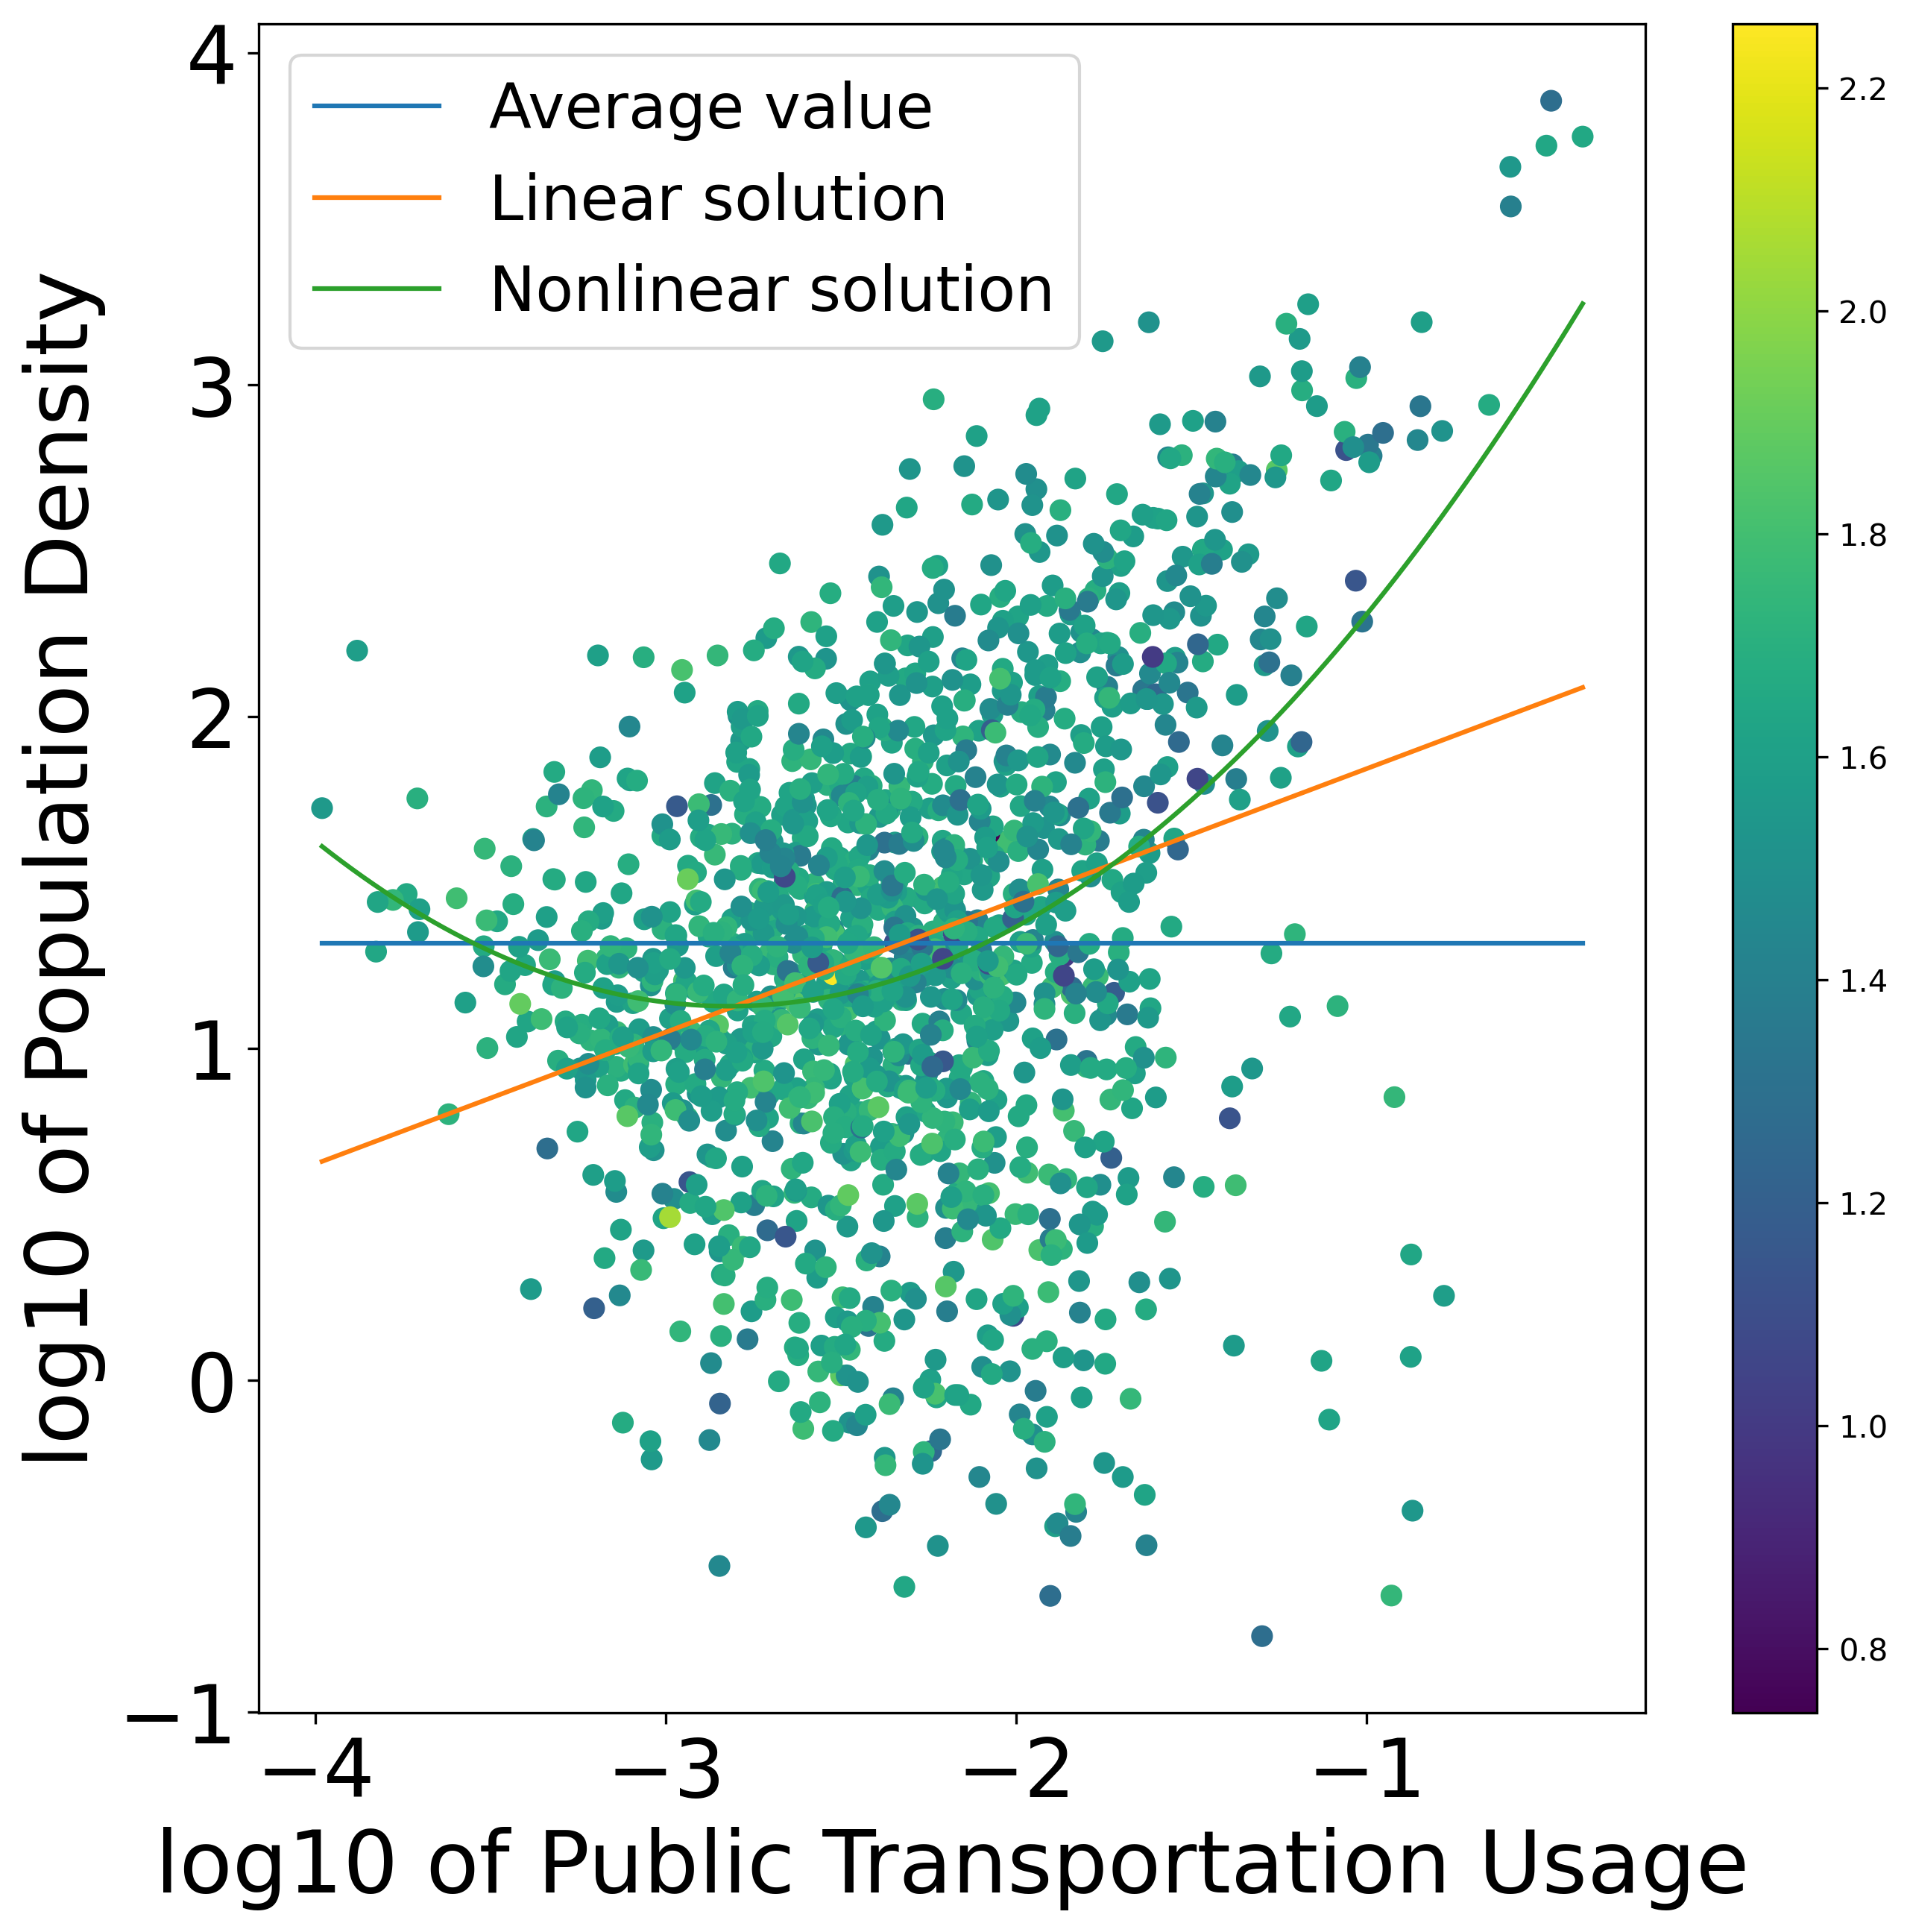

In [9]:
#stuff for linear regression
matrix = np.vstack((intercept, logtrans)).T
tmp = inv(np.matmul(np.transpose(matrix), matrix))
interceptvalue, slopetrans = tmp @ np.transpose(matrix) @ logdensity
print('Intercept is:', interceptvalue, "slope trans is:", slopetrans)
yi = interceptvalue + slopetrans*x1i
yf = interceptvalue + slopetrans*x1f
xarray = ([x1i, x1f])
yarray = ([yi, yf])

#nonlinear regression
errorvals = []
avals = []
bvals = []
cvals = []
bipolarrange = 1000
steps = 15
incrementsize = math.floor((bipolarrange*2)/steps)
if steps >= 15: 
    print('This may take a minute')
def error(params):
        a, b, c = params
        #array of guesses
        y = a*(logtrans**2) + logtrans*b + c
        #print(err)
        return np.sum((y-logdensity)**2)
for a in range(-bipolarrange, bipolarrange, incrementsize):
    for b in range (-bipolarrange, bipolarrange, incrementsize):
        for c in range (-bipolarrange, bipolarrange, incrementsize):
            ic = [a, b, c]
            sol = minimize(error, ic)
            avals.append(sol.x[0])
            bvals.append(sol.x[1])
            cvals.append(sol.x[2])
            errorvals.append(error(ic))
bins = 100
# plt.hist(avals, density = True, bins = bins)
# plt.title('Parameter a values')
# plt.show()
# plt.hist(bvals, density = True, bins = bins)
# plt.title('Parameter b values')
# plt.show()
# plt.hist(cvals, density = True, bins = bins)
# plt.title('Parameter c values')
# plt.show()
# plt.hist(errorvals, density = True, bins = bins)
# plt.title('Error function values')
# plt.show()
gooderrorvals = []
goodavals = []
goodbvals = []
goodcvals = []
for k in range(len(cvals)):
    if errorvals[k] <= ((np.max(errorvals)-np.min(errorvals)/10)+np.min(errorvals)):
        gooderrorvals.append(errorvals[k])
        goodavals.append(avals[k])
        goodbvals.append(bvals[k])
        goodcvals.append(cvals[k])
gooda = np.average(goodavals)
goodb = np.average(goodbvals)
goodc = np.average(goodcvals)
def nonlinmodel2(params):
    x1 = params
    y = gooda*(x1**2) + x1*goodb + goodc
    return(y)
nonlinyarray = []
nonlinx1array = np.linspace(x1i, x1f, 1000)
nonlinx2array = np.linspace(np.min(infperpop), np.max(infperpop), 1000)
for k in range(len(nonlinx1array)):
    l = nonlinx1array[k]
    nonlinyarray.append(nonlinmodel2(l))
averagexarray = [x1i, x1f]
averageyarray = [np.average(logdensity), np.average(logdensity)]

#plotting
fig, ax = plt.subplots(figsize = (10, 10), dpi = 300)
plt.scatter(logtrans, logdensity, c = np.log10(infperpop))
plt.plot(averagexarray, averageyarray, label = 'Average value')
plt.plot(xarray, yarray, label = 'Linear solution')
plt.plot(nonlinx1array, nonlinyarray, label = 'Nonlinear solution')
plt.xlabel('log10 of Public Transportation Usage', fontsize = 28)
plt.ylabel('log10 of Population Density', fontsize = 28)
ax.set(title='')
plt.legend(fontsize = 20)
plt.tick_params(labelsize=26)
plt.colorbar()
plt.plot()

#SST stuff
SST = 0
SSElin = 0
SSEnonlin = 0
for k in range(len(data.index)):
    y = data.loc[k, 'logdensity']
    logtransval = data.loc[k, 'logtrans']
    ylin = slopetrans*logtransval + interceptvalue
    ynonlin = gooda*(logtransval**2)+goodb*logtransval+goodc
    SST += ((y-np.average(logdensity))**2)
    SSElin += ((y-ylin)**2)
    SSEnonlin += ((y-ynonlin)**2)
print('SST =', SST, 'SSElin =', SSElin, 'SSEnonlin =', SSEnonlin, 'R^2 lin =', ((SST-SSElin)/SST), 'SSEnonlin R^2', ((SST-SSEnonlin)/SST))